In [1]:
import numpy as np
%matplotlib inline

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


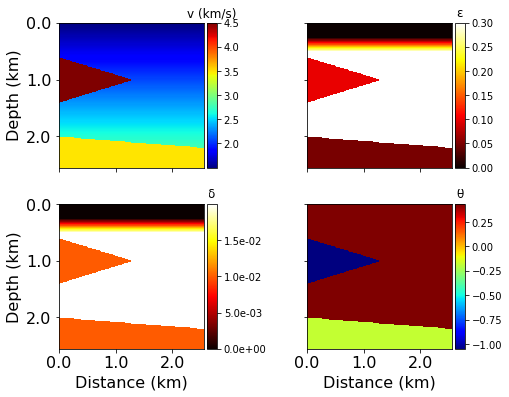

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, TimeAxis
from plot_parameters import plot

# Define a physical size
shape = (256, 256)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

space_order=8

#Load the velocity model and thomsem parameters
v = np.fromfile('models/new_models/vel.bin',dtype='float32')
epsilon = np.fromfile('models/new_models/epsilon.bin', dtype=np.float32)
delta = np.fromfile('models/new_models/delta.bin',dtype=np.float32)
theta = np.fromfile('models/new_models/theta.bin', dtype=np.float32)

v = np.reshape(v, shape)
epsilon = np.reshape(epsilon, shape)
delta = np.reshape(delta, shape)
theta = np.reshape(theta, shape)

# With the velocity, delta, epsilon, theta, phi and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 40 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbpml=40, epsilon=epsilon, delta=delta,
                  theta=theta)

plot(v,epsilon,delta,theta)

In [3]:
from examples.seismic import Model, AcquisitionGeometry

# Source and receiver geometries
src_coordinates = np.empty((1, len(spacing)))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = model.origin[-1] + 2 * spacing[-1]

nrec = shape[0]

rec_coordinates = np.empty((nrec, len(spacing)))
rec_coordinates[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec_coordinates[:, 1] = np.array(model.domain_size)[1] * .5
rec_coordinates[:, -1] = model.origin[-1] + 2 * spacing[-1]

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates,
                                   t0=0.0, tn=4000., src_type='Ricker', f0=0.015)
dt = model.critical_dt
print(dt)

0.738


In [4]:
from sympy import cos, sin, sqrt
from examples.seismic import PointSource, Receiver, RickerSource
from examples.seismic.tti.operators import kernel_centered_2d, Gxx_centered_2d,Gzz_centered_2d
from devito import TimeFunction
from devito import Eq, Operator, TimeFunction
from devito import ConditionalDimension

save=False
time_order=2
stagg_u = stagg_v = None
u = TimeFunction(name='u', grid=model.grid, staggered=stagg_u,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=space_order)
v = TimeFunction(name='v', grid=model.grid, staggered=stagg_v,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=space_order)

time_range=TimeAxis(start=0., stop=4000., step=dt)
src = RickerSource(name='src', grid=model.grid, f0=0.015,npoint=1, time_range=time_range)
rec = Receiver(name='rec', grid=model.grid, npoint=rec_coordinates.shape[0], time_range=time_range,
               coordinates=rec_coordinates)

stencils= kernel_centered_2d(model, u, v, space_order)

stencils += src.inject(field=u.forward, expr=src * dt**2 / model.m)
stencils += src.inject(field=v.forward, expr=src * dt**2 / model.m)
stencils += rec.interpolate(expr=u + v)

nsnaps = 100               # desired number of equally spaced snaps
nt = time_range.num
print(nt)
factor = round(nt / nsnaps)  # subsequent calculated factor
print(f"factor is {factor}")

time_subsampled = ConditionalDimension('t_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=space_order,
                     save=(nt + factor - 1) // factor, time_dim=time_subsampled)
vsave = TimeFunction(name='vsave', grid=model.grid, time_order=2, space_order=space_order,
                     save=(nt + factor - 1) // factor, time_dim=time_subsampled)

solver_tti = Operator(stencils+ [Eq(usave, u)] + [Eq(vsave, v)], subs=model.spacing_map, name='ForwardTTI')
#solver_tti = Operator(stencils, subs=model.spacing_map, name='ForwardTTI')

5422
factor is 54


In [5]:
src.coordinates.data[0, :]=src_coordinates[0]# just the first source
solver_tti(time=nt - 1, dt=model.critical_dt, rec=rec, src=src)
g= open('shot_TTI.file', 'wb')
print(rec.data.shape)
np.transpose(rec.data).astype('float32').tofile(g)

print("Saving snaps file")
print("Dimensions: nz = {:d}, nx = {:d}".format(shape[-1] + 2 * model.nbpml, shape[0] + 2 * model.nbpml))
filename = "snaps_TTI.bin"
usave.data.tofile(filename)

Operator `ForwardTTI` run in 17.51 s


(5422, 256)
Saving snaps file
Dimensions: nz = 336, nx = 336


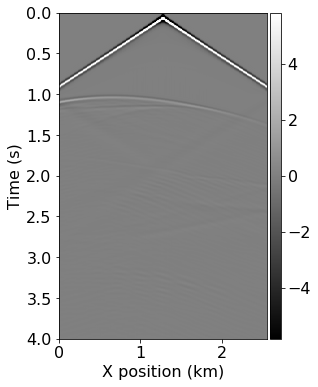

In [6]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, 0.0, 4000.)

In [7]:
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic.tti import AnisotropicWaveSolver

# Solvers
solver_tti = AnisotropicWaveSolver(model, geometry, time_order=2,space_order=space_order)

In [8]:
rec1, u, v, summary = solver_tti.forward()

Operator `ForwardTTI` run in 17.90 s


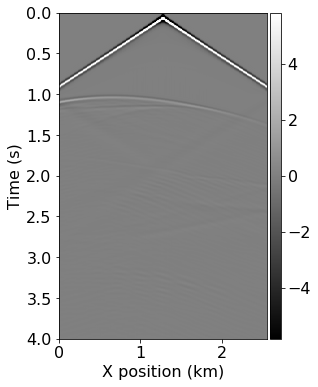

In [9]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec1.data, model, 0.0, 4000.)

In [ ]:
print(rec1.shape)